<center><h1>FlightRadar24 Analysis<h1>
<img src="https://images.flightradar24.com/opengraph/fr24_logo_twitter.png" alt="Flightradar24 Logo"></center>

In [2]:
# Surpress warnings:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

<h2>1: Gathering airports data and storing it in dataframe</h2>

In [5]:
import requests
import pandas as pd
import json

#We have to send headers or else it wont be able to capture the data as well as return blank page as output
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:109.0) Gecko/20100101 Firefox/114.0',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8',
    'Accept-Language': 'en-US,en;q=0.5'
}

#URL which contains airport data in JSON format..We make request by sending headers
req=requests.get('https://www.flightradar24.com/_json/airports.php',headers=headers)
data=req.text
#Here i noticed that , there is some noise in this data , so we use data manipulation and remove it
#This code will remove everything which occurs before ':[{"'
index = data.find(':[{"')
if index != -1:
    data = data[index+1:]

#Our data is almost ready , we need to remove the last curly and square brackets
data = data.replace(']}', ']')

#Storing data
data_json = json.loads(data)
airports=pd.DataFrame(data_json)

<h3>Lets check the shape and print first 5 rows</h3>

In [6]:
#Checking how many rows and columns airports dataframe got
airports.shape

(5103, 7)

In [40]:
airports.head()

,name,iata,icao,lat,lon,country,alt
0,A Coruna Airport,LCG,LECO,43.302059,-8.377250,Spain,326
1,Aachen Merzbruck Airport,AAH,EDKA,50.823051,6.186111,Germany,623
2,Aalborg Airport,AAL,EKYT,57.092781,9.849164,Denmark,10
3,Aarhus Airport,AAR,EKAH,56.300011,10.619000,Denmark,82
4,Aarhus Sea Airport,QEA,EKAC,56.151993,10.247725,Denmark,1


<h3>Lets Check their data types<h3>

In [8]:
airports.dtypes

name        object
iata        object
icao        object
lat        float64
lon        float64
country     object
alt         object
dtype: object

<h3>Lets change alt column datatype as int<h3>

In [9]:
airports['alt']=airports['alt'].astype(int)
airports.dtypes

name        object
iata        object
icao        object
lat        float64
lon        float64
country     object
alt          int32
dtype: object

<h3>Lets make a map and see how it looks</h3>

In [10]:
#Before making map , lets check out how many aiports does each country have

total_airports = airports.groupby('country')['name'].count().reset_index()
total_airports

,country,name
0,Afghanistan,10
1,Albania,2
2,Algeria,23
3,American Samoa,1
4,Angola,10
...,...,...
223,"Virgin Islands, Us",2
224,Wallis And Futuna,2
225,Yemen,5
226,Zambia,5


In [11]:
import folium


# Creating a map centered at an initial location
map = folium.Map(location=[airports['lat'].mean(), airports['lon'].mean()],zoom_start=2)

# Adding points to the map
for idx, row in airports.iterrows():
    folium.Marker([row['lat'], row['lon']], popup=row['name']).add_to(map)

# Display the map
map.save('map.html')

![Map](map.png)

<h3>Now this data isnt enough to do our analysis on , we need more , so lets gather data from different sources and merge it with airports dataframe
This is the site we are going to use: https://www.flightradar24.com/data/airports/"iata"/reviews , here in this link iata column will be iterated and will be replaced to gather each and every single airport's ratings , reviews , latest comment etc
I already gathered them and have attached it with this project as 1.csv</h2>

<h2>2: Merging 1.csv with airports dataframe</h2>

In [12]:
#We dont want any column names , so i will be using header as none
extra = pd.read_csv('1.csv', header=None)
extra.head(5)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,YXX,76.0,1.0,84.0,90,88,68,68,55,54,76,46,2018-10-13 14:42:03,Three flights scheduled to depart at the same ...
1,AHB,70.0,2.0,79.0,76,82,58,46,77,51,79,58,2017-12-28 17:14:41,Small regional airport with some international...
2,ABZ,72.0,16.0,82.0,80,79,68,74,66,78,72,67,2023-05-24 23:38:31,It took longer to get our bags than the flight...
3,AAL,83.0,10.0,90.0,93,92,83,80,75,79,83,70,2022-11-02 11:37:32,Very nice airport with free parking.\r\nFriend...
4,VJI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h3>Lets assign column names to make it readable and check its datatypes<h3>

In [13]:
#Assigning column names
extra.columns=['id','ratings','total_reviews','getting_to_the_airport','terminal_facilities','check_in','wifi','security_check','food_and_retail_services','longue','immigration','baggage_claim','latest_comment_date','latest_comment']
extra.head(5)

,id,ratings,total_reviews,getting_to_the_airport,terminal_facilities,check_in,wifi,security_check,food_and_retail_services,longue,immigration,baggage_claim,latest_comment_date,latest_comment
0,YXX,76.0,1.0,84.0,90,88,68,68,55,54,76,46,2018-10-13 14:42:03,Three flights scheduled to depart at the same ...
1,AHB,70.0,2.0,79.0,76,82,58,46,77,51,79,58,2017-12-28 17:14:41,Small regional airport with some international...
2,ABZ,72.0,16.0,82.0,80,79,68,74,66,78,72,67,2023-05-24 23:38:31,It took longer to get our bags than the flight...
3,AAL,83.0,10.0,90.0,93,92,83,80,75,79,83,70,2022-11-02 11:37:32,Very nice airport with free parking.\r\nFriend...
4,VJI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
#Checking datatype
extra.dtypes

id                           object
ratings                     float64
total_reviews               float64
getting_to_the_airport      float64
terminal_facilities          object
check_in                     object
wifi                         object
security_check               object
food_and_retail_services     object
longue                       object
immigration                  object
baggage_claim                object
latest_comment_date          object
latest_comment               object
dtype: object

In [15]:
#Shape
extra.shape

(5103, 14)

In [16]:
extra.isnull().sum()

id                             0
ratings                     2182
total_reviews               3421
getting_to_the_airport      1846
terminal_facilities         1848
check_in                    1868
wifi                        1924
security_check              1978
food_and_retail_services    2019
longue                      2077
immigration                 2488
baggage_claim               2568
latest_comment_date         3509
latest_comment              3531
dtype: int64

<h3>Lets start cleaning dataset by removing null values and changing the datatypes</h3>

In [17]:
#It is being assumed that if ratings and reviews columns are null , everything else will also be null
#Lets focus on the ones which got comments
extra=extra.query('ratings.notnull()&total_reviews.notnull()&latest_comment.notnull()')

In [18]:
extra.isnull().sum()

id                          0
ratings                     0
total_reviews               0
getting_to_the_airport      0
terminal_facilities         0
check_in                    0
wifi                        0
security_check              0
food_and_retail_services    0
longue                      0
immigration                 0
baggage_claim               0
latest_comment_date         0
latest_comment              0
dtype: int64

In [19]:
columns_to_convert = ['ratings','total_reviews','getting_to_the_airport','terminal_facilities', 'check_in', 'wifi', 'security_check',
                      'food_and_retail_services', 'longue', 'immigration', 'baggage_claim']

extra[columns_to_convert] = extra[columns_to_convert].astype(int)
extra['latest_comment_date']=pd.to_datetime(extra['latest_comment_date'])


In [20]:
extra.dtypes

id                                  object
ratings                              int32
total_reviews                        int32
getting_to_the_airport               int32
terminal_facilities                  int32
check_in                             int32
wifi                                 int32
security_check                       int32
food_and_retail_services             int32
longue                               int32
immigration                          int32
baggage_claim                        int32
latest_comment_date         datetime64[ns]
latest_comment                      object
dtype: object

In [21]:
extra.head(5)

,id,ratings,total_reviews,getting_to_the_airport,terminal_facilities,check_in,wifi,security_check,food_and_retail_services,longue,immigration,baggage_claim,latest_comment_date,latest_comment
0,YXX,76,1,84,90,88,68,68,55,54,76,46,2018-10-13 14:42:03,Three flights scheduled to depart at the same ...
1,AHB,70,2,79,76,82,58,46,77,51,79,58,2017-12-28 17:14:41,Small regional airport with some international...
2,ABZ,72,16,82,80,79,68,74,66,78,72,67,2023-05-24 23:38:31,It took longer to get our bags than the flight...
3,AAL,83,10,90,93,92,83,80,75,79,83,70,2022-11-02 11:37:32,Very nice airport with free parking.\r\nFriend...
5,LCG,77,6,79,87,83,76,65,73,74,67,82,2020-07-08 09:55:50,DECADENTE y personal muy borde y desagradable....


<h3>Our dataset is cleaned and is ready to be merged with airports dataframe</h3>

In [22]:
test = pd.merge(airports,extra,left_on=['iata'],right_on=['id'])
test.head(5)

,name,iata,icao,lat,lon,country,alt,id,ratings,total_reviews,...,terminal_facilities,check_in,wifi,security_check,food_and_retail_services,longue,immigration,baggage_claim,latest_comment_date,latest_comment
0,A Coruna Airport,LCG,LECO,43.302059,-8.377250,Spain,326,LCG,77,6,...,87,83,76,65,73,74,67,82,2020-07-08 09:55:50,DECADENTE y personal muy borde y desagradable....
1,Aalborg Airport,AAL,EKYT,57.092781,9.849164,Denmark,10,AAL,83,10,...,93,92,83,80,75,79,83,70,2022-11-02 11:37:32,Very nice airport with free parking.\r\nFriend...
2,Aarhus Airport,AAR,EKAH,56.300011,10.619000,Denmark,82,AAR,69,10,...,87,87,63,62,58,66,67,57,2023-05-08 10:15:45,Fantastic airport. \r\nLove that you can walk ...
3,Aarhus Sea Airport,QEA,EKAC,56.151993,10.247725,Denmark,1,QEA,91,1,...,100,73,75,73,100,60,100,70,2022-05-25 11:24:23,The sea airport is within the ferry and commer...
4,Abadan Airport,ABD,OIAA,30.371111,48.228329,Iran,19,ABD,54,2,...,64,60,73,50,64,76,80,80,2015-10-19 03:27:48,Airport name: Abadan Airport IATA code: ABD IC...


In [23]:
test.shape

(1563, 21)

<h3>Lets see what our map shows</h3>

In [24]:
import folium


# Creating a map centered at an initial location
new_map = folium.Map(location=[test['lat'].mean(), test['lon'].mean()],zoom_start=2)

# Adding points to the map
for idx, row in test.iterrows():
    folium.Marker([row['lat'], row['lon']], popup=row['name']).add_to(new_map)

# Display the map
new_map.save('new_map.html')

![Map](new_map.png)

<h3>Comparing both maps, it's apparent that fewer people seem to travel to remote locations such as Antarctica. This insight is intriguing, highlighting some distinct travel patterns. However, it's important to note that our analysis might not be entirely comprehensive. After all, there are numerous other platforms where travelers leave airport reviews.</h3>

<h2>3: Getting on with analysis</h2>

In [25]:
test.head()

,name,iata,icao,lat,lon,country,alt,id,ratings,total_reviews,...,terminal_facilities,check_in,wifi,security_check,food_and_retail_services,longue,immigration,baggage_claim,latest_comment_date,latest_comment
0,A Coruna Airport,LCG,LECO,43.302059,-8.377250,Spain,326,LCG,77,6,...,87,83,76,65,73,74,67,82,2020-07-08 09:55:50,DECADENTE y personal muy borde y desagradable....
1,Aalborg Airport,AAL,EKYT,57.092781,9.849164,Denmark,10,AAL,83,10,...,93,92,83,80,75,79,83,70,2022-11-02 11:37:32,Very nice airport with free parking.\r\nFriend...
2,Aarhus Airport,AAR,EKAH,56.300011,10.619000,Denmark,82,AAR,69,10,...,87,87,63,62,58,66,67,57,2023-05-08 10:15:45,Fantastic airport. \r\nLove that you can walk ...
3,Aarhus Sea Airport,QEA,EKAC,56.151993,10.247725,Denmark,1,QEA,91,1,...,100,73,75,73,100,60,100,70,2022-05-25 11:24:23,The sea airport is within the ferry and commer...
4,Abadan Airport,ABD,OIAA,30.371111,48.228329,Iran,19,ABD,54,2,...,64,60,73,50,64,76,80,80,2015-10-19 03:27:48,Airport name: Abadan Airport IATA code: ABD IC...


<h3>Best airport by country</h3>

In [34]:
import numpy as np

# Calculate a score where you multiply rating by the log of the total number of reviews
test['score'] = test['ratings'] * np.log(test['total_reviews'])

# Group the data by 'country' and find the row with the maximum score in each group
top_airports_in_each_country = test.loc[test.groupby('country')['score'].idxmax()]

top_airports_in_each_country[['name','country']].reset_index()


,index,name,country
0,629,Kabul International Airport,Afghanistan
1,1408,Tirana International Airport,Albania
2,44,Algiers Houari Boumediene Airport,Algeria
3,794,Luanda Quatro de Fevereiro Airport,Angola
4,1401,The Valley Clayton J. Lloyd International Airport,Anguilla
...,...,...,...
192,549,Ho Chi Minh City International Airport,Vietnam
193,139,Beef Island Terrance B. Lettsome Airport,"Virgin Islands, British"
194,1336,St. Thomas Cyril E. King Airport,"Virgin Islands, Us"
195,806,Lusaka Kenneth Kaunda International Airport,Zambia


In [28]:
import folium


# Creating a map centered at an initial location
top_airports = folium.Map(location=[top_airports_in_each_country['lat'].mean(), top_airports_in_each_country['lon'].mean()],zoom_start=2)

# Adding points to the map
for idx, row in top_airports_in_each_country.iterrows():
    folium.Marker([row['lat'], row['lon']], popup=row['name']).add_to(top_airports)

# Display the map
top_airports.save('top_airports.html')

![Map](top_airports.png)

<h3>Using weighted rating formula to get top 10%</h3>

In [45]:
# Calculate C
C = test['ratings'].mean()

# Calculate m
m = test['total_reviews'].quantile(0.90)  # Here we set a high cutoff for m

# Filter out all qualified airports into a new DataFrame
qualified_airports = test.copy().loc[test['total_reviews'] >= m]

# Calculate the weighted rating for each qualified airport
qualified_airports['weighted_rating'] = (qualified_airports['total_reviews']/(qualified_airports['total_reviews']+m) * qualified_airports['ratings']) + (m/(m+qualified_airports['total_reviews']) * C)

# Sort airports based on score calculated above
qualified_airports = qualified_airports.sort_values('weighted_rating', ascending=False)

#Top 100 airports
top_100_airports = qualified_airports.nlargest(100, 'weighted_rating')['name'].reset_index()
top_100_airports['name']


0                      Singapore Changi Airport
1               Hong Kong International Airport
2                   Dubai International Airport
3           Seoul Incheon International Airport
4                                Zurich Airport
                        ...                    
95                     Nice Cote d'Azur Airport
96                         Gran Canaria Airport
97    Delhi Indira Gandhi International Airport
98                               Lublin Airport
99                 Geneva International Airport
Name: name, Length: 100, dtype: object

<h3>We got our top 100 best airports , now lets see SKYTRAX's top 100 airports</h3>

In [38]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

url = 'https://www.worldairportawards.com/worlds-top-100-airports-2023/'

# Send a GET request to the website
response = requests.get(url)

# Parse the content of the request with BeautifulSoup
soup = BeautifulSoup(response.text, 'html.parser')

# Find all 'h4' elements with class 'mb-0 text-responsive-h4'
h4_tags = soup.find_all('h4', class_='mb-0 text-responsive-h4')

# Get the text of each h4 tag
airport_names = [tag.text for tag in h4_tags]

# Create a DataFrame
skytrax = pd.DataFrame(airport_names, columns=['Airport Name'])

# Print the DataFrame
skytrax


,Airport Name
0,Singapore Changi
1,Doha Hamad
2,Tokyo Haneda
3,Seoul Incheon
4,Paris CDG
...,...
95,Boston Logan
96,Changsha
97,Lyon
98,Minneapolis St.Paul


In [42]:
import pandas as pd

iatas = ["SIN", "DOH", "HND", "ICN", "CDG", "IST", "MUC", "ZRH", "NRT", "MAD",
        "VIE", "HEL", "FCO", "CPH", "KIX", "NGO", "DXB", "SEA", "MEL", "YVR",
        "DUS", "LHR", "BNE", "CAN", "FRA", "BAH", "RUH", "HAK", "AMS", "FUK",
        "SZX", "HOU", "HKG", "BCN", "IAH", "DEL", "BOG", "HAM", "ORY", "UIO",
        "JED", "MCT", "CGK", "DMM", "YUL", "CVG", "CPT", "SFO", "SYD", "SHA",
        "AKL", "MED", "GYD", "OOL", "LGW", "CGN", "LGA", "PER", "TFU", "ATH",
        "DUR", "ATL", "LAX", "YYZ", "HYD", "DFW", "KUL", "BKK", "BLR", "LCY",
        "DEN", "XIY", "ADL", "GMP", "JNB", "OSL", "BUD", "AGP", "MLA", "DPS",
        "OPO", "TPE", "LIS", "BOM", "ARN", "MXP", "AUH", "JFK", "LIM", "ALC",
        "PMI", "YYC", "KEF", "PHX", "ITM", "BOS", "CSX", "LYS", "MSP", "CHC"]

# Convert the list to a DataFrame
skytrax['Airport_Code'] = iatas
skytrax


,Airport Name,Airport_Code
0,Singapore Changi,SIN
1,Doha Hamad,DOH
2,Tokyo Haneda,HND
3,Seoul Incheon,ICN
4,Paris CDG,CDG
...,...,...
95,Boston Logan,BOS
96,Changsha,CSX
97,Lyon,LYS
98,Minneapolis St.Paul,MSP


<b>Let see the comparison between flightradar24's and skytrax's<b>

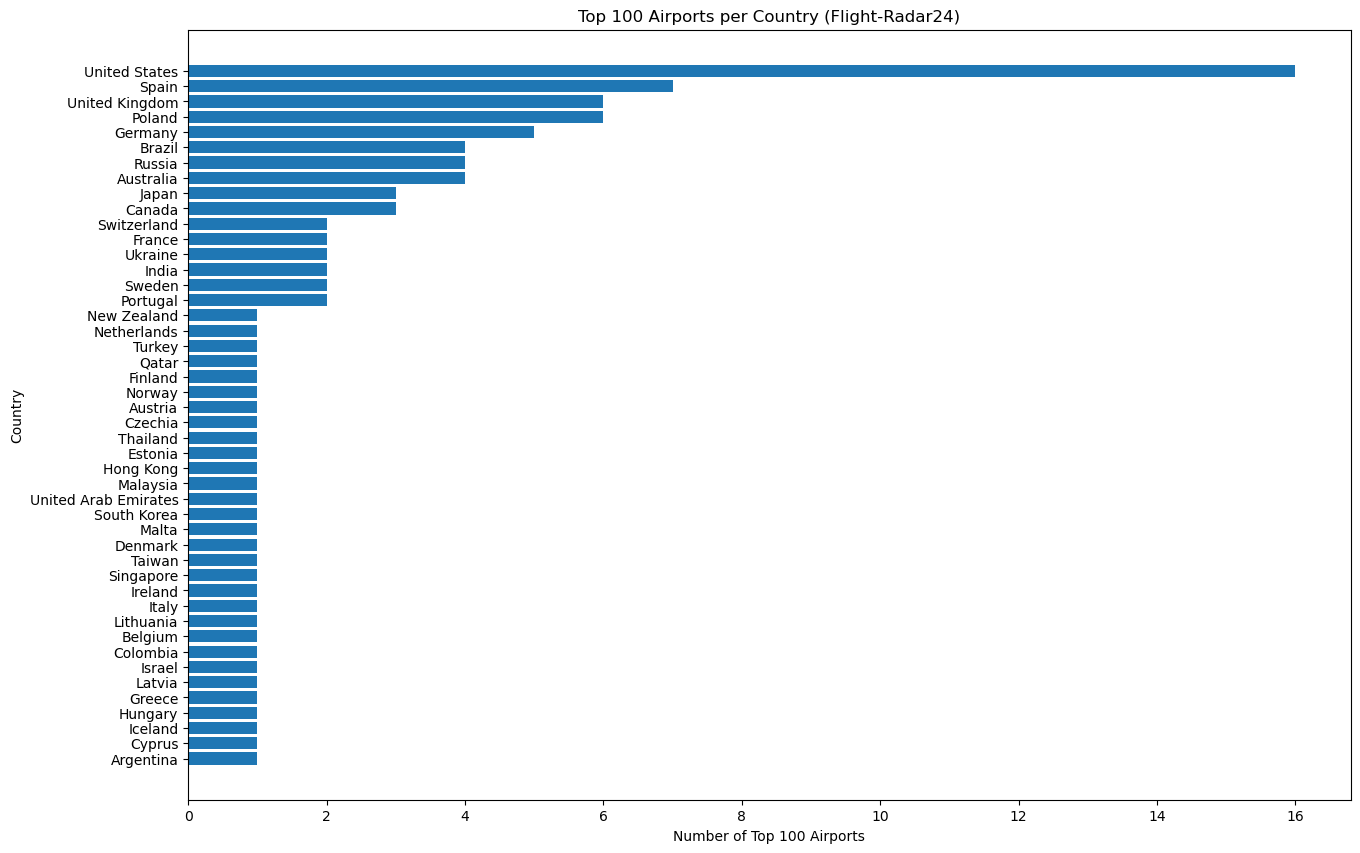

In [47]:
import matplotlib.pyplot as plt

# Get the count of airports per country
country_counts = qualified_airports.nlargest(100, 'weighted_rating')['country'].value_counts()

# Sort by the count of airports
country_counts = country_counts.sort_values(ascending=False)

# Generate the bar plot
plt.figure(figsize=(15, 10))
plt.barh(country_counts.index, country_counts.values)
plt.xlabel('Number of Top 100 Airports')
plt.ylabel('Country')
plt.title('Top 100 Airports per Country (Flight-Radar24)')
plt.gca().invert_yaxis()  # This is to start the bar chart with the country with most airports at the top
plt.show()


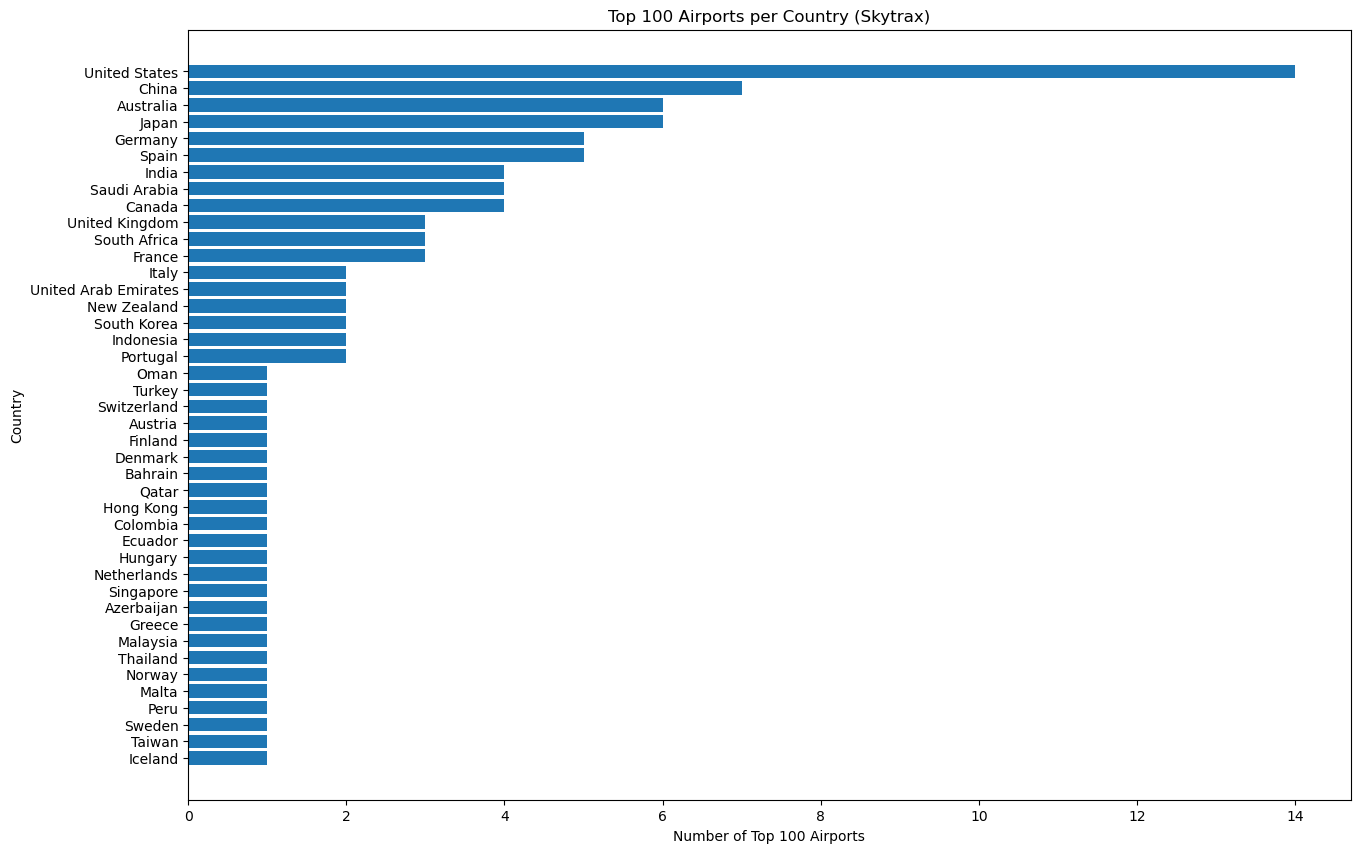

In [50]:
top_skytrax = pd.merge(skytrax,airports,left_on='Airport_Code',right_on='iata')
import matplotlib.pyplot as plt

# Get the count of airports per country
country_counts = top_skytrax['country'].value_counts()

# Sort by the count of airports
country_counts = country_counts.sort_values(ascending=False)

# Generate the bar plot
plt.figure(figsize=(15, 10))
plt.barh(country_counts.index, country_counts.values)
plt.xlabel('Number of Top 100 Airports')
plt.ylabel('Country')
plt.title('Top 100 Airports per Country (Skytrax)')
plt.gca().invert_yaxis()  # This is to start the bar chart with the country with most airports at the top
plt.show()


In [51]:
# Create a merged DataFrame of airports that appear in both lists
common_airports = pd.merge(qualified_airports, top_skytrax, on='iata')

# Calculate the percentage of common airports in each list
percentage_common_in_qualified = len(common_airports) / len(qualified_airports) * 100
percentage_common_in_skytrax = len(common_airports) / len(top_skytrax) * 100

print(f"Percentage of common airports in qualified_airports: {percentage_common_in_qualified}%")
print(f"Percentage of common airports in top_skytrax: {percentage_common_in_skytrax}%")


Percentage of common airports in qualified_airports: 43.47826086956522%
Percentage of common airports in top_skytrax: 70.0%


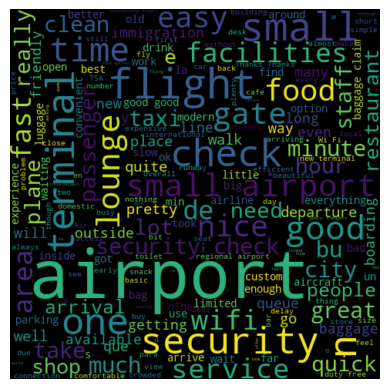

In [53]:
from wordcloud import WordCloud

# Combine all comments into one text
text = ' '.join(comment for comment in test['latest_comment'])

wordcloud = WordCloud(width=480, height=480, margin=0).generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

<h1>Conclusion</h1>

- Comparisons of top 100 airport lists from 'qualified_airports' and 'top_skytrax' data reveal a 43.48% and 70% overlap respectively, illustrating some consensus but also significant variations likely due to differing ranking methodologies or subjective factors.

- it's apparent that fewer people seem to travel to remote locations such as Antarctica. This insight is intriguing, highlighting some distinct travel patterns. However, it's important to note that our analysis might not be entirely comprehensive. After all, there are numerous other platforms where travelers leave airport reviews.

- Our word cloud brought out some interesting highlights! Travelers chatting about their airport experiences have mostly been buzzing about 'service', 'cleanliness', 'security', and 'food'. Surprisingly, 'Wifi' wasn't as big of a chatter generator as we might have expected, but that could be because we were zooming in on the freshest comments.

- It was also noticed that in flightradar24's reviews section , most comments were made on 2022 and the skytrax data is of 2023 , therefore leaving a huge gap

- Unanimously, both Skytrax and Flightradar24 crown "Singapore Changi Airport (SIN)" as the top-rated airport.


Overall, I truly enjoyed undertaking this project. It took me two days of research to identify the best sources of data. The process of gathering information from various sources and merging them was especially satisfying.

While the analysis I performed was quite comprehensive, there's potential for further deep dive analysis, particularly on the comments and ratings. This could reveal specific areas of improvement for the airports. However, accomplishing this would likely require the creation of a bot or the use of Selenium to collect the necessary data.

On a side note, I noticed that the security of Flightradar24 could potentially be improved. It seems there's no rate limiting for IP addresses, making it susceptible to DDoS attacks. After making 18 continuous requests to their API and Site, my connection was blocked. Whether this was a security measure from their end or an issue with my bot is unclear.
